In [1]:
%matplotlib inline
import numpy as np
import random

random.seed(0)
np.random.seed(0)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.mixture import GaussianMixture
import scipy.stats as stats


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
import scipy
import warnings
from math import sqrt, ceil
from collections import Counter

# sklearnのTransformerにしたので、fit_tramsformを呼ぶと外れ値の閾値を返す
class OutlyerModel(BaseEstimator, TransformerMixin):
    def __init__(self, p = 0.99, search_list = list(range(1, 70)), minmax = False, parcentile=0.0001, warning_filter=True):
        random.seed(0)
        self._p = p
        self._search_list = search_list
        self._component_selection_method = self.parcentile
        self._parcentile = parcentile
        self._warning_filter = warning_filter
        if minmax:
            self._component_selection_method = self.minmax


    # 各インデックスのクラス数のBICを計算、もしくはキャッシュから得る
    def get_bic(self, index, x):
        bics = self.bics_
        gmms = self.gmms_
        if (bics[index] is None):
            if self._warning_filter:
                warnings.filterwarnings('ignore')
            gmm = GaussianMixture(n_components=self._search_list[index], reg_covar=1.0e-3)
            gmm = gmm.fit(x)
            bic = gmm.bic(x)
            gmms[index] = gmm
            bics[index] = bic
            self.gmm_fit_count_ += 1
            return bic
        return bics[index]


    def gmm_search(self, x):
        # 最小のBICのクラス数を三分探索をする
        # https://qiita.com/DaikiSuyama/items/84df26daad11cf7da453
        sarch_list_size = len(self._search_list)
        left = 0
        right = sarch_list_size - 1

        self.gmms_ = [None] * sarch_list_size
        self.bics_ = [None] * sarch_list_size

        self.gmm_fit_count_ = 0

        # right=left,left+1,left+2のいずれかになれば探索終了
        while(left + 2 < right):
            centor1 = left + (right - left) // 3
            centor2 = right - (right - left) // 3

            # 3分点を計算する
            centor1_bic = self.get_bic(centor1, x)
            centor2_bic = self.get_bic(centor2, x)
            if centor1_bic < centor2_bic:
                right = centor2
            else:
                left = centor1

        # left-rightの間の最小値が最小値
        min_bic = float('inf')
        min_index = -1
        for i in range(left, right+1):
            bic = self.get_bic(i, x)
            if bic < min_bic:
                min_bic = bic
                min_index = i
        self.min_index_ = min_index
        self.gmm_ = self.gmms_[min_index]
        self.n_components_ = self._search_list[min_index]
        return


    def fit(self, X):
        return self


    def predict(self, X):
        x = X.reshape((-1,1))
        return self.gmm_.predict(x)


    def minmax(self, x):
        # シンプルに最大峰と最小峰を選択
        means = self.gmm_.means_
        return np.argmin(means), np.argmax(means)

    def parcentile(self, x):
        # parcentileで指定されたパーセンタイルを含むcomponentの中で最大と最小で外れ値を判断する
        # selectsに指定されたパーセンタイルになるまでindexを集める
        components = self.gmm_.predict(x)
        size = len(components)
        parcentile = self._parcentile
        counter = Counter(components)
        sum = 0
        selects = []
        for i, count in counter.most_common():
            selects.append(i)
            sum += count
            if sum / size > (1 - self._parcentile):
                break
        
        # selectsに集まった平均値の中から最大と最小の平均値のindexを得る
        max_mean = -float('inf')
        min_mean = float('inf')
        max_index = 0
        min_index = 0
        means = self.gmm_.means_
        for i in selects:
            if max_mean < means[i]:
                max_index = i
                max_mean = means[i]
            if means[i] < min_mean:
                min_index = i
                min_mean = means[i]
        return min_index, max_index


    def transform(self, X):
        # 最良のbicが得られるgmmを探索する
        self.size_ = len(X)
        x_reshaped = X.reshape((-1,1))
        self.x_ = X
        self.gmm_search(x_reshaped)

        # # 推定結果のうち、最大の物と最小の物の分布でホテリング法を用いて99%閾値を求める
        # # ホテリングのT2（1次元）の逆関数で閾値を確率から求める
        # # https://tjo.hatenablog.com/entry/2017/02/08/190000
        # gmm = self.gmm_
        # index_min, index_max = self._component_selection_method(x)
        # self.min_component_ = index_min
        # self.max_component_ = index_max
        # mu = gmm.means_[index_max]
        # s2 = gmm.covariances_[index_max]
        # thr = scipy.stats.chi2.ppf(self._p, 1)
        # thr_high = (2 * mu + sqrt((mu * -2) ** 2 - 4 * (mu ** 2 - thr * s2))) / 2
        # mu = gmm.means_[index_min]
        # s2 = gmm.covariances_[index_min]
        # thr_low = (2 * mu - sqrt((mu * -2) ** 2 - 4 * (mu ** 2 - thr * s2))) / 2

        # σプロットから閾値を計算する
        # σプロットの3-5σの領域から推定
        # 3-5σの領域が離散的だったら、5σがあれば、5σ、なければ最大、最小を使う
        hist, bin_edges = np.histogram(X, 200)
        x = np.mean(np.stack([bin_edges[:-1], bin_edges[1:]], axis=1), axis=1)
        cumsum_hists = np.cumsum(hist)
        sigmas = calc_sigma(cumsum_hists, np.full(len(cumsum_hists), cumsum_hists[-1]))
        print(f'-3s: {np.where(sigmas > -3)[0][0]}')
        print(f'+3s: {np.where(sigmas >  3)[0][0]}')
        print(f'-5s: {np.where(sigmas > -5)[0][0]}')
        print(f'+5s: {np.where(sigmas >  5)[0][0]}')

        thr_low = 0
        thr_high = 0

        self.thr_low_ = thr_low
        self.thr_high_ = thr_high
        reject_count = len(X[(X < thr_low) | (X > thr_high)])
        self.reject_count_ = reject_count
        self.reject_rate_ = reject_count / float(self.size_)
        return thr_low, thr_high, self.reject_rate_


    def plot(self, search_ax = None, hist_ax = None, prob_ax = None):
        self.plot_search_component(search_ax)
        self.plot_hist(hist_ax)
        self.plot_prob(prob_ax)
        ax = plt.figure().add_subplot()
        self.sigma_plot(self.x_, ax = ax)
        _, bin_edges = np.histogram(self.x_, 200)
        #x = np.mean(np.stack([bin_edges[:-1], bin_edges[1:]], axis=1), axis=1)
        expand = (bin_edges[-1] - bin_edges[0])
        x = np.linspace(bin_edges[0] - expand, bin_edges[-1] + expand, 200 * 100)
        gmm_pdf = self.GMMPDF(self.gmm_, x.shape[0])
        counts = gmm_pdf.pdf(x)
        cumsum_counts = np.cumsum(counts)
        sigmas = calc_sigma(cumsum_counts, np.full(len(cumsum_counts), cumsum_counts[-1]))
        select = (-5 < sigmas) & (sigmas < 5)
        x = x[select]
        sigmas = sigmas[select]
        ax.plot(x, sigmas)


    def plot_search_component(self, ax = None, recalc_full_bic=False):
        if ax is None:
            ax = plt.figure().add_subplot()
        
        n_search = sum(x is not None for x in self.bics_)
        if recalc_full_bic:
            for i in range(len(self._search_list)):
                self.get_bic(i, self.x_)
        ax.plot(self._search_list, self.bics_)
        s = f"components: {self.n_components_}\nsearch: {n_search}"
        ax.text(0.99, 0.99, s, va='top', ha='right', transform=ax.transAxes)


    def plot_hist(self, ax = None):
        if ax is None:
            ax = plt.figure().add_subplot()

        bin = ceil(sqrt(self.size_))
        ax.hist(self.x_, bins=bin, log=True)
        ax.axvline(self.thr_low_, ymin=0, ymax=1, color="red", linestyle='--')
        ax.axvline(self.thr_high_, ymin=0, ymax=1, color="red", linestyle='--')
        ax.text(self.thr_low_, ax.axis()[3], str(self.thr_low_), va="top", ha="left")
        ax.text(self.thr_high_, ax.axis()[3], str(self.thr_high_), va="top", ha="right")
        ax.text(1.02, 0.5, f"reject_rate:{self.reject_rate_:.3e}", va="center", transform=ax.transAxes, rotation=270)

    def plot_prob(self, ax = None):
        if ax is None:
            ax = plt.figure().add_subplot()

        # 分布のラインを描画
        bin = ceil(sqrt(self.size_))
        ax.hist(self.x_, bins=bin)
        x = np.linspace(np.min(self.x_), np.max(self.x_), bin if bin >= 100 else 100)
        gmm = self.gmm_
        y_sum = np.zeros(x.shape[0])
        ys = np.zeros((self.n_components_, x.shape[0]))
        for i in range(self.n_components_):
            gd = scipy.stats.norm.pdf(x, gmm.means_[i, -1], np.sqrt(gmm.covariances_[i]))
            y = gmm.weights_[i] * gd
            y = y[0]
            ys[i] = y
            y_sum += y
        magnify = self.size_ / np.sum(y_sum)
        y_sum *= magnify
        ys *= magnify
        for i in range(self.n_components_):
            ax.plot(x, ys[i], label=f'components: {i}', color = "red", alpha=0.5)
        ax.plot(x, y_sum, label=f'components: {i}', color = "red")
        ax.axvline(self.thr_low_, ymin=0, ymax=1, color="red", linestyle='--')
        ax.axvline(self.thr_high_, ymin=0, ymax=1, color="red", linestyle='--')

    def calc_sigma(self, x, all):
        return stats.norm.ppf((x-0.3)/(all+0.4))

    def sigma_plot_from_hist(self, counts, bins, bin_is_edge = True, ax=None):
        if ax is None:
            ax = plt.figure().add_subplot()

        if bin_is_edge:
            x = np.mean(np.stack([bins[:-1], bins[1:]], axis=1), axis=1)
        else:
            x = bins

        cumsum_counts = np.cumsum(counts)
        sigmas = calc_sigma(cumsum_counts, np.full(len(cumsum_counts), cumsum_counts[-1]))

        ax.plot(x, sigmas)

    def sigma_plot(self, x, bin_num=200, ax=None):
        counts, bins = np.histogram(x, bin_num)
        sigma_plot_from_hist(counts, bins, ax)

    def sigma_plot_from_pdf(self, f, bins, ax=None):
        x = np.mean(np.stack([bins[:-1], bins[1:]], axis=1), axis=1)
        counts = f(x)
        sigma_plot_from_hist(counts, bins, ax=ax)

    class GMMPDF:
        def __init__(self, gmm, n_size):
            self.gmm = gmm
            self.n_size = n_size

        def pdf(self, x):
            gmm = self.gmm
            y = np.zeros(x.shape[0])
            for i in range(gmm.n_components):
                y += stats.norm.pdf(x, gmm.means_.reshape(-1)[i], np.sqrt(gmm.covariances_.reshape(-1)[i]))*gmm.weights_[i]
            magnify = self.n_size / np.sum(y)
            return y * magnify

In [3]:
import scipy.stats as stats

def calc_sigma(x, all):
    return stats.norm.ppf(x/all)

def sigma_plot_from_hist(counts, bins, ax=None):
    if ax is None:
        ax = plt.figure().add_subplot()

    x = np.mean(np.stack([bins[:-1], bins[1:]], axis=1), axis=1)

    cumsum_counts = np.cumsum(counts)
    sigmas = np.vectorize(calc_sigma)(cumsum_counts, np.full(len(cumsum_counts), cumsum_counts[-1]))

    ax.plot(x, sigmas)

def sigma_plot(x, bin_num=200, ax=None):
    counts, bins = np.histogram(x, bin_num)
    sigma_plot_from_hist(counts, bins, ax)

def sigma_plot_from_pdf(f, bins, ax=None):
    x = np.mean(np.stack([bins[:-1], bins[1:]], axis=1), axis=1)
    counts = np.vectorize(f)(x)
    sigma_plot_from_hist(counts, bins, ax=None)

class GMMPDF:
    def __init__(self, gmm):
        self.gmm = gmm

    def pdf(self, x):
        gmm = self.gmm
        return stats.norm.pdf(x, gmm.means_.reshape(-1), gmm.covariances_.reshape(-1))*gmm.weights_

In [4]:
y = np.random.poisson(lam=1.0, size=100000)
y = np.append(y, np.random.poisson(lam=2.0, size=100000) + 3)
y[1999] = 10

-3s: 0
+3s: 142
-5s: 0
+5s: 199


(0, 0, 0.81654)

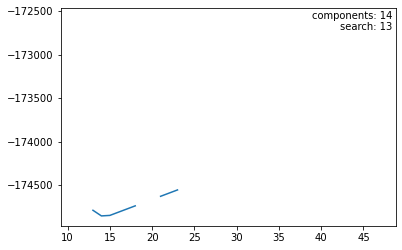

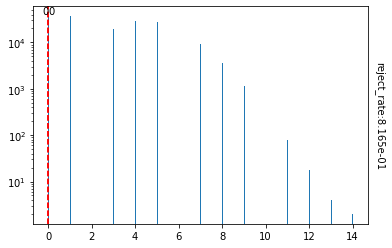

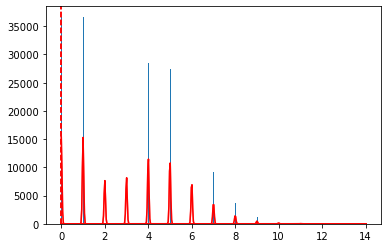

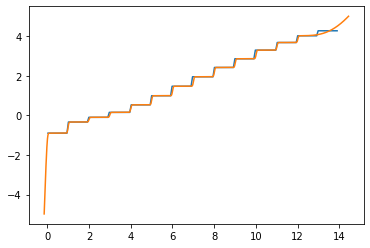

In [5]:
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

以下、データバリエーション

# 正規分布3峰

In [6]:
y = np.random.normal(loc=10, scale=5, size=40000)
y = np.append(y, np.random.normal(loc=100, scale=10, size=30000))
y = np.append(y, np.random.normal(loc=500, scale=20, size=20000))

-3s: 2
+3s: 190
-5s: 0
+5s: 199


(0, 0, 1.0)

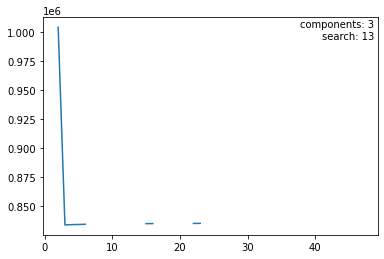

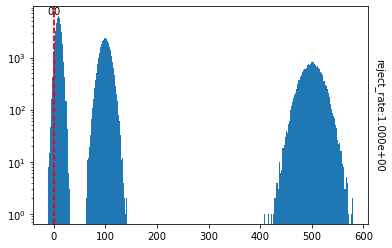

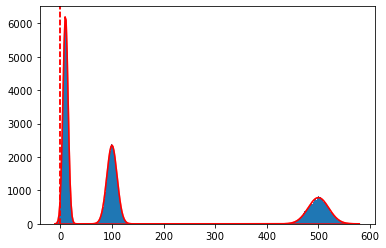

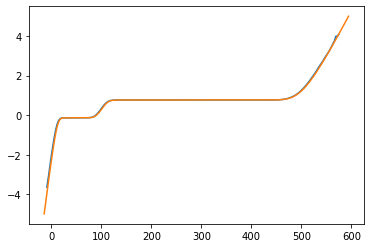

In [7]:
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

In [8]:
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
y = df["petal length (cm)"].values

-3s: 0
+3s: 199
-5s: 0
+5s: 199


(0, 0, 1.0)

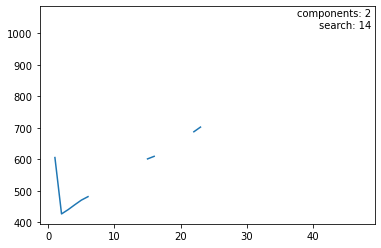

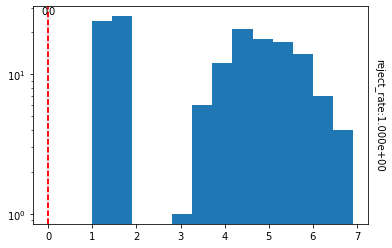

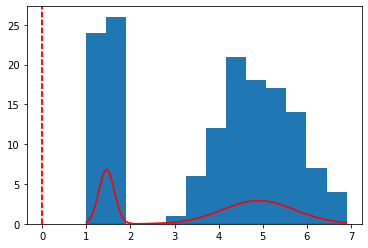

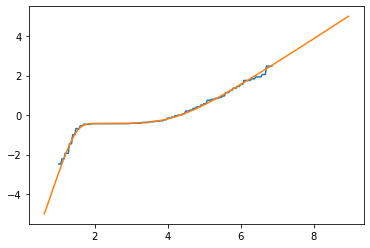

In [9]:
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

# ポアソン分布

-3s: 0
+3s: 100
-5s: 0
+5s: 199


(0, 0, 0.6346)

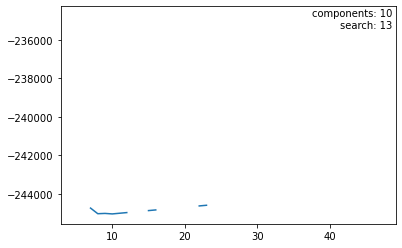

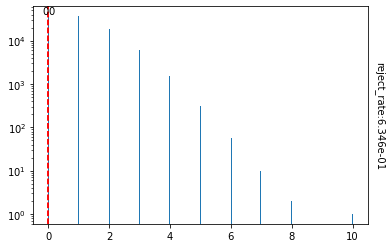

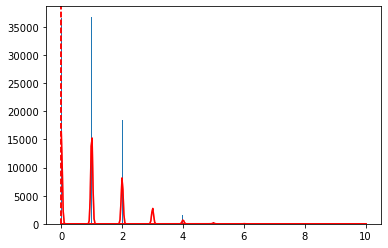

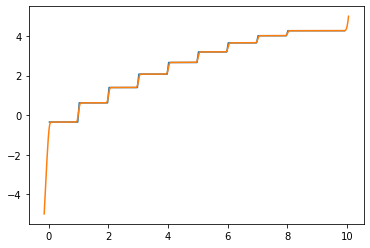

In [10]:
y = np.random.poisson(lam=1.0, size=100000)
y[0] = 10
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

# ポアソンと正規分布混合

-3s: 22
+3s: 160
-5s: 0
+5s: 199


(0, 0, 0.991125)

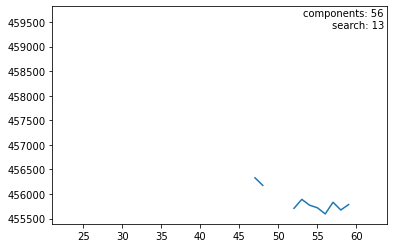

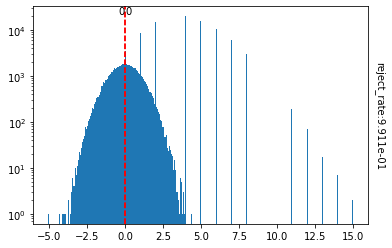

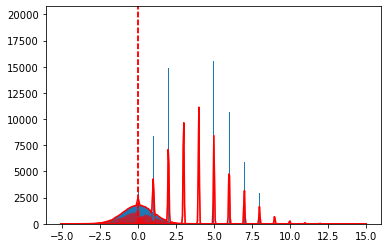

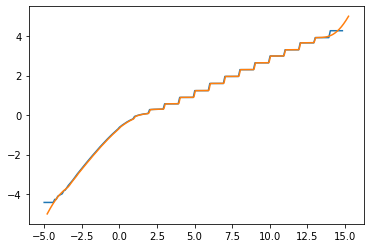

In [11]:
y = np.random.poisson(lam=4.0, size=100000)
y = np.append(y, np.random.normal(size=100000))
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

# 整数一様分布

-3s: 16
+3s: 179
-5s: 0
+5s: 199


(0, 0, 1.0)

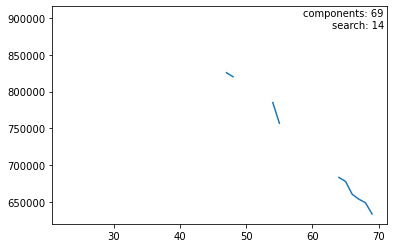

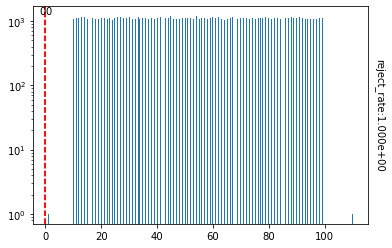

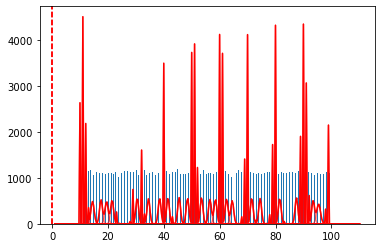

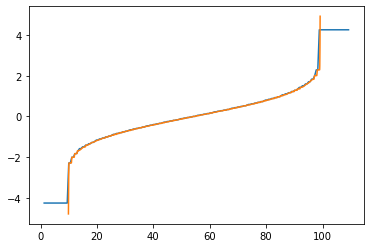

In [12]:
y = np.random.randint(10, 100, size=100000)
y[1] = 110
y[2] = 1
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

-3s: 70
+3s: 130
-5s: 0
+5s: 199


(0, 0, 1.0)

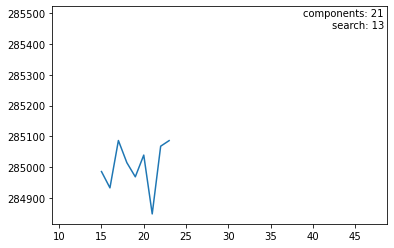

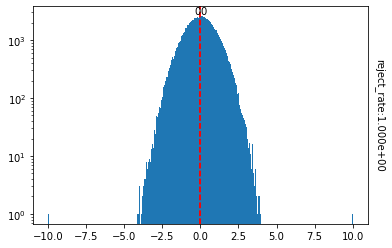

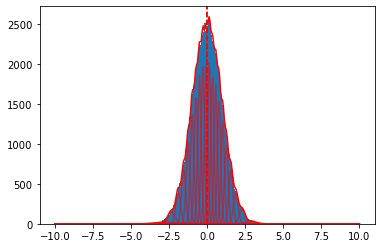

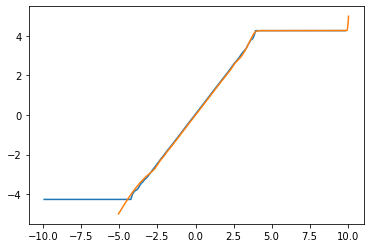

In [13]:
y = np.random.normal(size=100000)
y[0] = 10
y[1] = -10

outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

-3s: 18
+3s: 179
-5s: 0
+5s: 199


(0, 0, 0.99999)

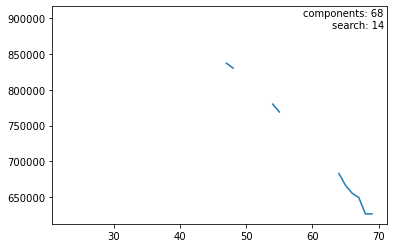

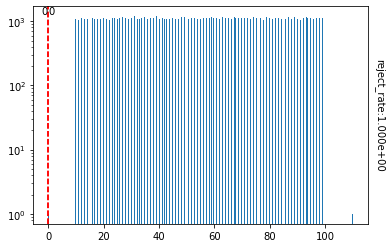

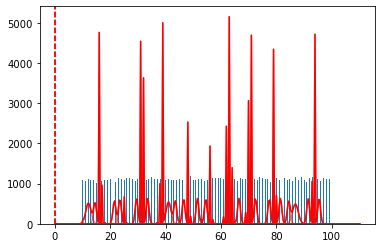

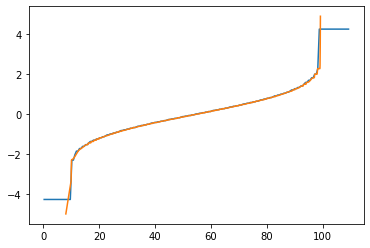

In [14]:
y = np.random.randint(10, 100, size=100000)
y[0] = 0
y[1] = 110
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()

-3s: 12
+3s: 186
-5s: 0
+5s: 199


(0, 0, 1.0)

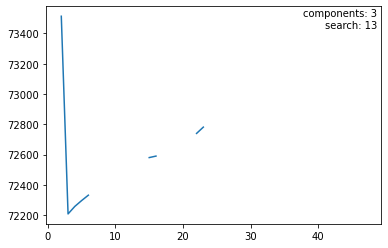

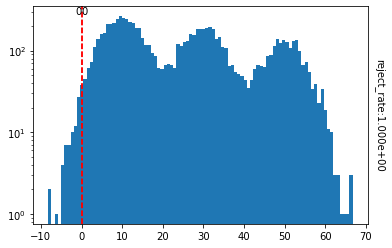

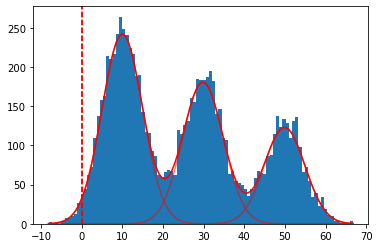

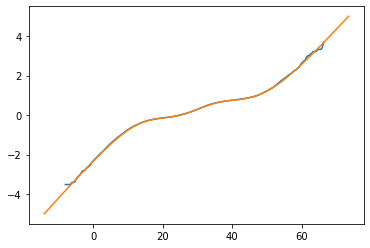

In [15]:
y = np.random.normal(loc=10, scale=5, size=4000)
y = np.append(y, np.random.normal(loc=30, scale=5, size=3000))
y = np.append(y, np.random.normal(loc=50, scale=5, size=2000))
outlyer = OutlyerModel()
display(outlyer.fit_transform(y))
outlyer.plot()